In [1]:
import pandas as pd
import acquire
import wrangle
import numpy as np
import math
from sklearn import metrics

# import to determine entropy for anomaly detection
from scipy.stats import entropy

#to filter warnings
import warnings
warnings.filterwarnings("ignore")

# for pliotting
import matplotlib.pyplot as plt
#to format dates on our plots
import matplotlib.dates as mdates #to format dates on our plots
%matplotlib inline
import seaborn as sns

# This is to make sure matplotlib doesn't throw the following error:
# The next line fixes "TypeError: float() argument must be a string or a number, not 'Timestamp' matplotlib"
pd.plotting.register_matplotlib_converters()

# writing original gzip csv to dataframe
# df = pd.read_csv('anonymized-curriculum-access.txt.gz', compression='gzip', header=None, sep=' ', quotechar='"', error_bad_lines=False)

In [2]:
df = acquire.acquire_curr_logs()
df.head(2)

,date,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0


In [3]:
df.shape

(900223, 15)

### Takeaways:
- 900,223 observations
- some duplicate features

### Wrangle:
- Rename columns name to more descriptive names
- dropped unnecessary columns: 'deleted_at','updated_at','created_at','start_date','end_date','slack','cohort_id', 'id'
- Replaced program ids with names: web_dev, staff, data_sci, other
- concat date and time columns, rename and change data type, delete original columns
- split year, month, day and hour to create individual columns for exploration



In [4]:
df = wrangle.wrangle_curr_logs(df)
df

,path,user,cohort_id,ip,id,cohort,slack,start_date,end_date,created_at,updated_at,deleted_at,program,year,month,day,hour,weekday
datetime,,,,,,,,,,,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,2018,1,26,9,Friday
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,2018,1,26,9,Friday
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,2018,1,26,9,Friday
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,2018,1,26,9,Friday
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2.0,2018,1,26,9,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-21 16:41:51,jquery/personal-site,64,28.0,71.150.217.33,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2.0,2021,4,21,16,Wednesday
2021-04-21 16:42:02,jquery/mapbox-api,64,28.0,71.150.217.33,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2.0,2021,4,21,16,Wednesday
2021-04-21 16:42:09,jquery/ajax/weather-map,64,28.0,71.150.217.33,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2.0,2021,4,21,16,Wednesday


In [5]:
ds = df.loc[df.program == 3]
staff = df.loc[df.cohort == 'Staff']
web_dev = df.loc[df.program == 1]
other = df.loc[df.program == 0]
staff

,path,user,cohort_id,ip,id,cohort,slack,start_date,end_date,created_at,updated_at,deleted_at,program,year,month,day,hour,weekday
datetime,,,,,,,,,,,,,,,,,,
2018-12-06 14:15:29,appendix/further-reading/java/intellij-tomcat-...,53,28.0,97.105.19.58,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2.0,2018,12,6,14,Thursday
2018-12-06 14:25:40,javascript-i,314,28.0,97.105.19.58,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2.0,2018,12,6,14,Thursday
2018-12-06 14:25:41,javascript-i/coffee-project,314,28.0,97.105.19.58,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2.0,2018,12,6,14,Thursday
2018-12-06 15:31:29,spring,40,28.0,170.248.173.247,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2.0,2018,12,6,15,Thursday
2018-12-06 15:31:33,spring/fundamentals/security,40,28.0,170.248.173.247,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2.0,2018,12,6,15,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-21 16:41:51,jquery/personal-site,64,28.0,71.150.217.33,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2.0,2021,4,21,16,Wednesday
2021-04-21 16:42:02,jquery/mapbox-api,64,28.0,71.150.217.33,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2.0,2021,4,21,16,Wednesday
2021-04-21 16:42:09,jquery/ajax/weather-map,64,28.0,71.150.217.33,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2.0,2021,4,21,16,Wednesday


In [6]:
staff.user.value_counts()

11     15178
64     12530
428     5819
1       5787
248     5027
314     4617
53      4132
545     3528
211     3162
581     2961
546     2585
514     2073
315     2042
404     1668
816     1527
742     1507
480     1256
146     1216
521     1088
430      981
744      651
951      583
893      402
572      390
37       374
502      357
618      318
397      305
630      253
41       204
257      160
308      151
513      132
854      131
312      131
738      128
653      117
953       85
539       84
40        66
620       58
370       54
813       49
855       47
745       46
894       29
148       26
461       11
980        3
652        1
592        1
Name: user, dtype: int64

In [7]:
ds

,path,user,cohort_id,ip,id,cohort,slack,start_date,end_date,created_at,updated_at,deleted_at,program,year,month,day,hour,weekday
datetime,,,,,,,,,,,,,,,,,,
2019-08-20 09:39:58,/,466,34.0,97.105.19.58,34.0,Bayes,#,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,None,3.0,2019,8,20,9,Tuesday
2019-08-20 09:39:59,/,467,34.0,97.105.19.58,34.0,Bayes,#,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,None,3.0,2019,8,20,9,Tuesday
2019-08-20 09:39:59,/,468,34.0,97.105.19.58,34.0,Bayes,#,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,None,3.0,2019,8,20,9,Tuesday
2019-08-20 09:40:02,/,469,34.0,97.105.19.58,34.0,Bayes,#,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,None,3.0,2019,8,20,9,Tuesday
2019-08-20 09:40:08,/,470,34.0,97.105.19.58,34.0,Bayes,#,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,None,3.0,2019,8,20,9,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-21 16:14:16,regression/project,841,133.0,99.162.244.233,133.0,Easley,#easley,2020-12-07,2021-06-08,2020-12-07 15:20:18,2020-12-07 15:20:18,None,3.0,2021,4,21,16,Wednesday
2021-04-21 16:15:51,regression/project,841,133.0,99.162.244.233,133.0,Easley,#easley,2020-12-07,2021-06-08,2020-12-07 15:20:18,2020-12-07 15:20:18,None,3.0,2021,4,21,16,Wednesday
2021-04-21 16:23:53,/,143,133.0,173.174.194.60,133.0,Easley,#easley,2020-12-07,2021-06-08,2020-12-07 15:20:18,2020-12-07 15:20:18,None,3.0,2021,4,21,16,Wednesday


In [8]:
ds.cohort.value_counts()

Darden      32015
Bayes       26538
Curie       21582
Easley      14715
Florence     8562
Name: cohort, dtype: int64

### <font color = 'red'>Note:

- User 152, Apollo cohort, program = other; only five appearances (all after hours on 3/22/2018)

In [9]:
df.loc[df.user == 152]

,path,user,cohort_id,ip,id,cohort,slack,start_date,end_date,created_at,updated_at,deleted_at,program,year,month,day,hour,weekday
datetime,,,,,,,,,,,,,,,,,,
2018-03-22 19:01:49,/,152,9.0,207.68.209.17,9.0,Apollo,#apollo,2015-03-30,2015-07-29,2016-06-14 19:52:26,2016-06-14 19:52:26,None,4.0,2018,3,22,19,Thursday
2018-03-22 19:01:54,content/html-css,152,9.0,207.68.209.17,9.0,Apollo,#apollo,2015-03-30,2015-07-29,2016-06-14 19:52:26,2016-06-14 19:52:26,None,4.0,2018,3,22,19,Thursday
2018-03-22 19:01:54,content/html-css/gitbook/images/favicon.ico,152,9.0,207.68.209.17,9.0,Apollo,#apollo,2015-03-30,2015-07-29,2016-06-14 19:52:26,2016-06-14 19:52:26,None,4.0,2018,3,22,19,Thursday
2018-03-22 19:02:47,content/html-css,152,9.0,207.68.209.17,9.0,Apollo,#apollo,2015-03-30,2015-07-29,2016-06-14 19:52:26,2016-06-14 19:52:26,None,4.0,2018,3,22,19,Thursday
2018-03-22 19:02:52,content/html-css/introduction.html,152,9.0,207.68.209.17,9.0,Apollo,#apollo,2015-03-30,2015-07-29,2016-06-14 19:52:26,2016-06-14 19:52:26,None,4.0,2018,3,22,19,Thursday


### Looking for Entropy in IP addresses

- **entropy of 0 indicates there is no uncertainty** (the value will always be one value)
- **entropy of 1 indicates every value is different.** 
- When using entropy in anomaly detection, **a field with a low, but not 0, entropy is likely to contain an anomalous value.**
- This will not catch all anomalies, but it is another tool to put in your toolbox.

In [10]:
# Look at the distribution of the frequency of ip addresses


In [11]:
# create dataframe out of value counts
ip_counts = pd.DataFrame(df.ip.value_counts()).reset_index()
ip_counts.head()

,index,ip
0,97.105.19.58,284579
1,97.105.19.61,61662
2,192.171.117.210,9515
3,71.150.217.33,6791
4,76.185.145.231,4754


In [12]:
# rename columns
ip_counts.columns=['ip', 'event_count']
ip_counts.event_count

0       284579
1        61662
2         9515
3         6791
4         4754
         ...  
5526         1
5527         1
5528         1
5529         1
5530         1
Name: event_count, Length: 5531, dtype: int64

In [13]:
# get the number of ip addresses seen 1, or 2, or 11,998 times. 
# ip_counts.groupby(['event_count']).count()

# Why is entropy > 1????

In [14]:
from scipy.stats import entropy

# pass the entropy function an array-like object of counts. 
entropy(ip_counts.event_count)

4.989681160017426

# Find IP addresses that only occur once

In [15]:


# filter where event_count == 1
ip_counts[ip_counts['event_count'] == 1]

,ip,event_count
4709,104.237.80.144,1
4710,174.207.7.100,1
4711,99.203.26.125,1
4712,70.238.240.119,1
4713,172.85.210.26,1
...,...,...
5526,107.181.165.202,1
5527,63.97.8.66,1
5528,107.77.220.17,1
5529,65.36.96.192,1


In [16]:
staff.head()

,path,user,cohort_id,ip,id,cohort,slack,start_date,end_date,created_at,updated_at,deleted_at,program,year,month,day,hour,weekday
datetime,,,,,,,,,,,,,,,,,,
2018-12-06 14:15:29,appendix/further-reading/java/intellij-tomcat-...,53,28.0,97.105.19.58,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2.0,2018,12,6,14,Thursday
2018-12-06 14:25:40,javascript-i,314,28.0,97.105.19.58,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2.0,2018,12,6,14,Thursday
2018-12-06 14:25:41,javascript-i/coffee-project,314,28.0,97.105.19.58,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2.0,2018,12,6,14,Thursday
2018-12-06 15:31:29,spring,40,28.0,170.248.173.247,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2.0,2018,12,6,15,Thursday
2018-12-06 15:31:33,spring/fundamentals/security,40,28.0,170.248.173.247,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2.0,2018,12,6,15,Thursday


### Takeaways
- Out of 5531 unique ip addresses,
- 822 ip addresses only occur once
- Entropy function returns - 4.99, which indicates

### Examining Easley

In [17]:
easley = df.loc[df.cohort == 'Easley']
easley

,path,user,cohort_id,ip,id,cohort,slack,start_date,end_date,created_at,updated_at,deleted_at,program,year,month,day,hour,weekday
datetime,,,,,,,,,,,,,,,,,,
2020-12-08 10:49:37,/,835,133.0,173.173.109.5,133.0,Easley,#easley,2020-12-07,2021-06-08,2020-12-07 15:20:18,2020-12-07 15:20:18,None,3.0,2020,12,8,10,Tuesday
2020-12-08 10:49:39,/,836,133.0,99.43.137.186,133.0,Easley,#easley,2020-12-07,2021-06-08,2020-12-07 15:20:18,2020-12-07 15:20:18,None,3.0,2020,12,8,10,Tuesday
2020-12-08 10:49:40,/,837,133.0,66.69.79.82,133.0,Easley,#easley,2020-12-07,2021-06-08,2020-12-07 15:20:18,2020-12-07 15:20:18,None,3.0,2020,12,8,10,Tuesday
2020-12-08 10:49:52,/,838,133.0,99.158.249.67,133.0,Easley,#easley,2020-12-07,2021-06-08,2020-12-07 15:20:18,2020-12-07 15:20:18,None,3.0,2020,12,8,10,Tuesday
2020-12-08 10:50:16,/,839,133.0,130.45.49.89,133.0,Easley,#easley,2020-12-07,2021-06-08,2020-12-07 15:20:18,2020-12-07 15:20:18,None,3.0,2020,12,8,10,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-21 16:14:16,regression/project,841,133.0,99.162.244.233,133.0,Easley,#easley,2020-12-07,2021-06-08,2020-12-07 15:20:18,2020-12-07 15:20:18,None,3.0,2021,4,21,16,Wednesday
2021-04-21 16:15:51,regression/project,841,133.0,99.162.244.233,133.0,Easley,#easley,2020-12-07,2021-06-08,2020-12-07 15:20:18,2020-12-07 15:20:18,None,3.0,2021,4,21,16,Wednesday
2021-04-21 16:23:53,/,143,133.0,173.174.194.60,133.0,Easley,#easley,2020-12-07,2021-06-08,2020-12-07 15:20:18,2020-12-07 15:20:18,None,3.0,2021,4,21,16,Wednesday


In [18]:
easley.user.value_counts()

845    1891
841    1414
844    1152
837    1131
840    1018
835     974
847     909
143     808
838     798
836     795
851     778
849     744
848     653
842     608
843     550
846     400
839      92
Name: user, dtype: int64

In [19]:
easley.ip.value_counts()

148.66.39.72      1875
24.160.7.8        1152
173.173.109.5      974
173.174.194.60     894
130.45.49.89       849
                  ... 
172.58.110.172       1
172.58.102.219       1
172.58.102.191       1
172.58.107.129       1
172.58.70.176        1
Name: ip, Length: 202, dtype: int64

In [20]:
easley.groupby(["hour", "user"]).count()


path  cohort_id  ip  id  cohort  slack  start_date  end_date  \
hour user                                                                 
0    835     19         19  19  19      19     19          19        19   
     836      2          2   2   2       2      2           2         2   
     837      2          2   2   2       2      2           2         2   
     838     46         46  46  46      46     46          46        46   
     840     10         10  10  10      10     10          10        10   
...         ...        ...  ..  ..     ...    ...         ...       ...   
23   845     16         16  16  16      16     16          16        16   
     847      1          1   1   1       1      1           1         1   
     848      1          1   1   1       1      1           1         1   
     849     11         11  11  11      11     11          11        11   
     851      1          1   1   1       1      1           1         1   

           created_at  updated_at  deleted_at  program  year  month  day  \
hour user                                                                  
0    835           19          19           0       19    19     19   19   
     836            2           2           0        2     2      2    2   
     837            2           2           0        2     2      2    2   
     838           46          46           0       46    46     46   46   
     840           10          10           0       10    10     10   10   
...               ...         ...         ...      ...   ...    ...  ...   
23   845           16          16           0       16    16     16   16   
     847            1           1           0        1     1      1    1   
     848            1           1           0        1     1      1    1   
     849           11          11           0       11    11     11   11   
     851            1           1           0        1     1      1    1   

           weekday  
hour user           
0    835        19  
     836         2  
     837         2  
     838        46  
     840        10  
...            ...  
23   845        16  
     847         1  
     848         1  
     849        11  
     851         1  

[294 rows x 16 columns]

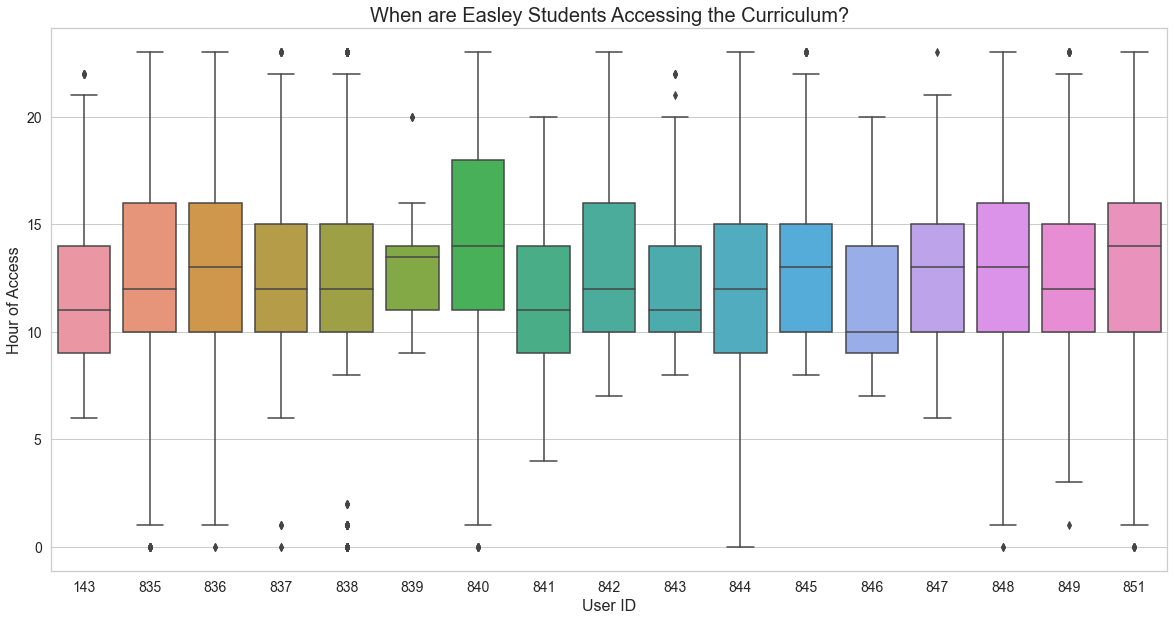

In [21]:
## create box plot comparing user access times
import seaborn as sns
sns.set(rc={'figure.figsize':(20,10)})
sns.set_theme(style="whitegrid")
sns.boxplot(data = easley, x='user', y='hour')
plt.title('When are Easley Students Accessing the Curriculum?', fontsize=20)
plt.xlabel('User ID', fontsize=16)
plt.ylabel('Hour of Access', fontsize=16)
plt.tick_params(labelsize=14)
plt.show()

In [22]:
ds.columns

Index(['path', 'user', 'cohort_id', 'ip', 'id', 'cohort', 'slack',
       'start_date', 'end_date', 'created_at', 'updated_at', 'deleted_at',
       'program', 'year', 'month', 'day', 'hour', 'weekday'],
      dtype='object')

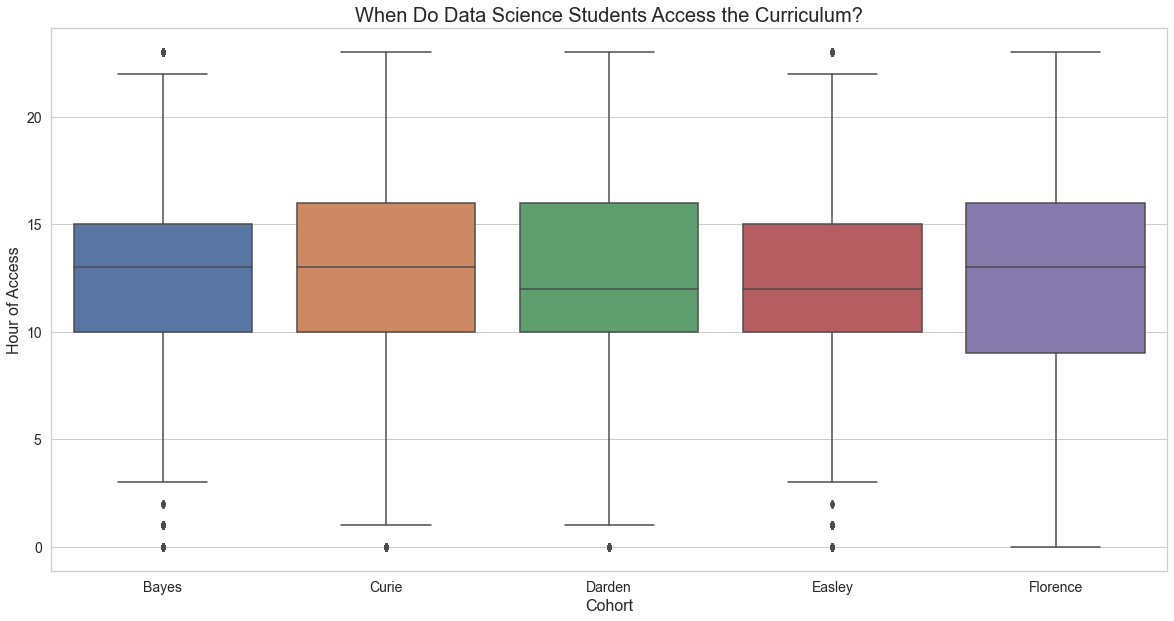

In [23]:
## create box plot comparing user access times
import seaborn as sns
sns.set(rc={'figure.figsize':(20,10)})
sns.set_theme(style="whitegrid")
sns.boxplot(data = ds, x= 'cohort', y='hour')
plt.title('When Do Data Science Students Access the Curriculum?', fontsize=20)
plt.xlabel('Cohort', fontsize=16)
plt.ylabel('Hour of Access', fontsize=16)
plt.tick_params(labelsize=14)
plt.show()

In [24]:
staff.columns

Index(['path', 'user', 'cohort_id', 'ip', 'id', 'cohort', 'slack',
       'start_date', 'end_date', 'created_at', 'updated_at', 'deleted_at',
       'program', 'year', 'month', 'day', 'hour', 'weekday'],
      dtype='object')

In [25]:
ds.cohort.value_counts()

Darden      32015
Bayes       26538
Curie       21582
Easley      14715
Florence     8562
Name: cohort, dtype: int64

In [26]:
staff.user.value_counts()

11     15178
64     12530
428     5819
1       5787
248     5027
314     4617
53      4132
545     3528
211     3162
581     2961
546     2585
514     2073
315     2042
404     1668
816     1527
742     1507
480     1256
146     1216
521     1088
430      981
744      651
951      583
893      402
572      390
37       374
502      357
618      318
397      305
630      253
41       204
257      160
308      151
513      132
854      131
312      131
738      128
653      117
953       85
539       84
40        66
620       58
370       54
813       49
855       47
745       46
894       29
148       26
461       11
980        3
652        1
592        1
Name: user, dtype: int64

In [27]:
## create box plot comparing user access times

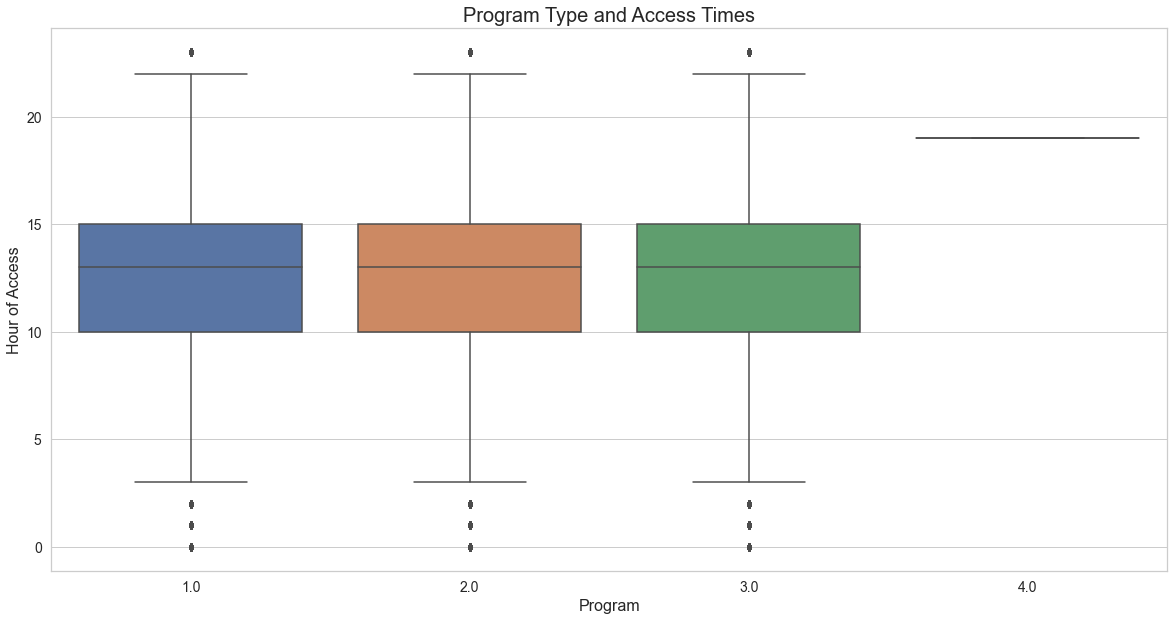

In [28]:
## create box plot comparing user access times
import seaborn as sns
sns.set(rc={'figure.figsize':(20,10)})
sns.set_theme(style="whitegrid")
sns.boxplot(data = df, x='program', y='hour')
plt.title('Program Type and Access Times', fontsize=20)
plt.xlabel('Program', fontsize=16)
plt.ylabel('Hour of Access', fontsize=16)
plt.tick_params(labelsize=14)
plt.show()

In [29]:
web_dev = df.loc[df.program == 'web_dev']
web_dev.head()

,path,user,cohort_id,ip,id,cohort,slack,start_date,end_date,created_at,updated_at,deleted_at,program,year,month,day,hour,weekday
datetime,,,,,,,,,,,,,,,,,,


In [30]:
web_dev.path.value_counts()

Series([], Name: path, dtype: int64)

In [31]:
df.columns

Index(['path', 'user', 'cohort_id', 'ip', 'id', 'cohort', 'slack',
       'start_date', 'end_date', 'created_at', 'updated_at', 'deleted_at',
       'program', 'year', 'month', 'day', 'hour', 'weekday'],
      dtype='object')

In [32]:
df.groupby(df.path)

In [33]:
web_dev.groupby(["path"]).count()

,user,cohort_id,ip,id,cohort,slack,start_date,end_date,created_at,updated_at,deleted_at,program,year,month,day,hour,weekday
path,,,,,,,,,,,,,,,,,


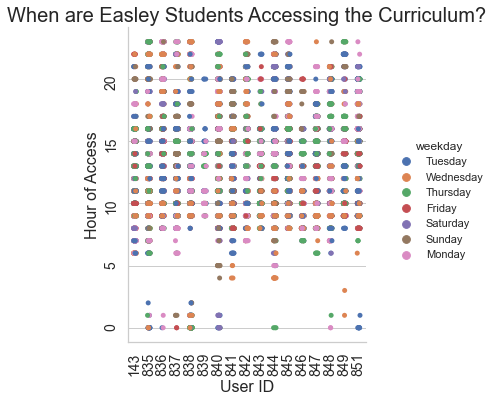

In [34]:
## create caqt plot comparing user access times
# sns.set(rc={'figure.figsize':(20,10)})
sns.catplot(x="user", y="hour", hue="weekday", data=easley,height=5, aspect=.8)
sns.set_theme(style="whitegrid")
plt.title('When are Easley Students Accessing the Curriculum?', fontsize=20)
plt.xlabel('User ID', fontsize=16)
plt.ylabel('Hour of Access', fontsize=16)
plt.tick_params(labelsize=14, rotation = 90)
plt.show()

### Finding myself (by ip address)

In [36]:
me = df.loc[df.ip == '162.222.247.26']

In [39]:
me.head()

,path,user,cohort_id,ip,id,cohort,slack,start_date,end_date,created_at,updated_at,deleted_at,program,year,month,day,hour,weekday
datetime,,,,,,,,,,,,,,,,,,
2021-02-22 11:12:17,/,840,133.0,162.222.247.26,133.0,Easley,#easley,2020-12-07,2021-06-08,2020-12-07 15:20:18,2020-12-07 15:20:18,None,3.0,2021,2,22,11,Monday
2021-02-22 11:12:35,classification/overview,840,133.0,162.222.247.26,133.0,Easley,#easley,2020-12-07,2021-06-08,2020-12-07 15:20:18,2020-12-07 15:20:18,None,3.0,2021,2,22,11,Monday
2021-02-22 11:12:35,classification/scale_features_or_not.svg,840,133.0,162.222.247.26,133.0,Easley,#easley,2020-12-07,2021-06-08,2020-12-07 15:20:18,2020-12-07 15:20:18,None,3.0,2021,2,22,11,Monday
2021-02-22 11:12:35,classification/classical_programming_vs_machin...,840,133.0,162.222.247.26,133.0,Easley,#easley,2020-12-07,2021-06-08,2020-12-07 15:20:18,2020-12-07 15:20:18,None,3.0,2021,2,22,11,Monday
2021-02-22 12:06:03,classification/acquire,840,133.0,162.222.247.26,133.0,Easley,#easley,2020-12-07,2021-06-08,2020-12-07 15:20:18,2020-12-07 15:20:18,None,3.0,2021,2,22,12,Monday


In [ ]:
### 

In [38]:
late = me.loc[me.hour >= 22]

,path,user,cohort_id,ip,id,cohort,slack,start_date,end_date,created_at,updated_at,deleted_at,program,year,month,day,hour,weekday
datetime,,,,,,,,,,,,,,,,,,
2021-03-07 22:31:42,/,840,133.0,162.222.247.26,133.0,Easley,#easley,2020-12-07,2021-06-08,2020-12-07 15:20:18,2020-12-07 15:20:18,None,3.0,2021,3,7,22,Sunday
2021-03-07 22:32:32,classification/prep,840,133.0,162.222.247.26,133.0,Easley,#easley,2020-12-07,2021-06-08,2020-12-07 15:20:18,2020-12-07 15:20:18,None,3.0,2021,3,7,22,Sunday
2021-03-08 23:37:37,/,840,133.0,162.222.247.26,133.0,Easley,#easley,2020-12-07,2021-06-08,2020-12-07 15:20:18,2020-12-07 15:20:18,None,3.0,2021,3,8,23,Monday
2021-03-10 22:36:53,/,840,133.0,162.222.247.26,133.0,Easley,#easley,2020-12-07,2021-06-08,2020-12-07 15:20:18,2020-12-07 15:20:18,None,3.0,2021,3,10,22,Wednesday
2021-03-10 22:37:10,regression/overview,840,133.0,162.222.247.26,133.0,Easley,#easley,2020-12-07,2021-06-08,2020-12-07 15:20:18,2020-12-07 15:20:18,None,3.0,2021,3,10,22,Wednesday
2021-03-10 22:37:13,timeseries/acquire,840,133.0,162.222.247.26,133.0,Easley,#easley,2020-12-07,2021-06-08,2020-12-07 15:20:18,2020-12-07 15:20:18,None,3.0,2021,3,10,22,Wednesday
2021-03-10 22:38:28,regression/acquire-and-prep,840,133.0,162.222.247.26,133.0,Easley,#easley,2020-12-07,2021-06-08,2020-12-07 15:20:18,2020-12-07 15:20:18,None,3.0,2021,3,10,22,Wednesday
2021-03-10 22:38:59,regression/split-and-scale,840,133.0,162.222.247.26,133.0,Easley,#easley,2020-12-07,2021-06-08,2020-12-07 15:20:18,2020-12-07 15:20:18,None,3.0,2021,3,10,22,Wednesday
2021-03-10 22:39:38,regression/project,840,133.0,162.222.247.26,133.0,Easley,#easley,2020-12-07,2021-06-08,2020-12-07 15:20:18,2020-12-07 15:20:18,None,3.0,2021,3,10,22,Wednesday


### Working early/late 


In [ ]:
# after 8 pm
me.loc[me.hour > 20]

In [ ]:
# before 9 am
me.loc[me.hour < 9]

In [ ]:
me.path.value_counts()

In [ ]:
# create dataframe out of value counts
ip_counts = pd.DataFrame(df.ip.value_counts()).reset_index()

ip_counts

In [ ]:
# rename columns
ip_counts.columns=['ip', 'event_count']
ip_counts

In [ ]:
# get the number of ip addresses seen 1, or 2, or 11,998 times. 
ip_counts.groupby(['event_count']).count()

In [ ]:
once = ip_counts.loc[ip_counts.event_count == 1]
twice = ip_counts.loc[ip_counts.event_count == 2]
many = ip_counts.loc[ip_counts.event_count >= 15000]
many


In [ ]:
# Takeaways 
- 822 ips seen only once
- 554 seen only twice
- >= 15000 - only two  (97.105.19.61 and 97.105.19.58) both owned by codeup